## 1. Data Preprocessing

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

import pyspark.sql.functions as F
from pyspark.sql import Row, dataframe
from pyspark.sql.types import StructField, TimestampType, StructType, LongType, FloatType, StringType
from pyspark.ml.feature import StringIndexer, Bucketizer
from pyspark.ml import Pipeline

Matplotlib is building the font cache; this may take a moment.


### 1.1 Rating Dataset: Hawaii

In [9]:
#download the dataset 
!wget --no-check-certificate https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal/rating-Hawaii.csv.gz
!hadoop fs -put rating-Hawaii.csv.gz /

--2024-04-28 17:55:09--  https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal/rating-Hawaii.csv.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 59010060 (56M) [application/x-gzip]
Saving to: ‘rating-Hawaii.csv.gz’

rating-Hawaii.csv.g 100%[===================>]  56.28M  4.36MB/s    in 7.6s    

2024-04-28 17:55:17 (7.40 MB/s) - ‘rating-Hawaii.csv.gz’ saved [59010060/59010060]



In [10]:
#set the standard path and filename
#check the name and IP port of your Hadoop NameNode
filename = "hdfs://st446-cluster-project-m.europe-west2-c.c.st446-project-420620.internal.:8020/rating-Hawaii.csv.gz"

In [11]:
#shema for the dataset
rating_schema = StructType([
    StructField("business", StringType(), True),    
    StructField("user", StringType(), True),
    StructField("rating", FloatType(), True),
    StructField("timestamp", LongType(), True)
])

#loading the dataset
hi_ratings = spark.read.csv(filename, header=True, schema=rating_schema)

#print some samples
for x in hi_ratings.head(5):
  print(x) 

Row(business='0x7c00456eecad3111:0x8217f9600c51f33', user='114563412185193956773', rating=2.0, timestamp=1625986477698)
Row(business='0x7c00456eecad3111:0x8217f9600c51f33', user='106014068654963315795', rating=1.0, timestamp=1623740696466)
Row(business='0x7c00456eecad3111:0x8217f9600c51f33', user='106135943668689718830', rating=5.0, timestamp=1529699397115)
Row(business='0x7c00456eecad3111:0x8217f9600c51f33', user='100824151868133017941', rating=5.0, timestamp=1582583419814)
Row(business='0x7c00456eecad3111:0x8217f9600c51f33', user='109900744991405705942', rating=5.0, timestamp=1527050588314)


In [12]:
#turn the timestamp into normal time format
hi_ratings = hi_ratings.withColumn("timestamp", F.from_unixtime(F.col("timestamp") / 1000)) 

In [6]:
#check the null values in the rating dataset
if hi_ratings.dropna().count() == hi_ratings.count():
    print("There is no null values in the rating dataset.")
else:
    print("There are null values in the rating dataset.")

There is no null values in the rating dataset.


### 1.2 Meta Dataset: Hawaii

In [14]:
#download the meta dataset
!wget --no-check-certificate https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal/meta-Hawaii.json.gz
!hadoop fs -put meta-Hawaii.json.gz /     

#set the standard path and filename
#check the name and IP port of your Hadoop NameNode
filename = "hdfs://st446-cluster-project-m.europe-west2-c.c.st446-project-420620.internal.:8020/meta-Hawaii.json.gz"

--2024-04-28 17:56:08--  https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal/meta-Hawaii.json.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 4859295 (4.6M) [application/x-gzip]
Saving to: ‘meta-Hawaii.json.gz’

meta-Hawaii.json.gz 100%[===================>]   4.63M  4.15MB/s    in 1.1s    

2024-04-28 17:56:09 (4.15 MB/s) - ‘meta-Hawaii.json.gz’ saved [4859295/4859295]



In [15]:
#shema for the dataset
meta_schema = StructType([
    StructField("name", StringType(), True),    
    StructField("address", StringType(), True),
    StructField("gmap_id", StringType(), True),
    StructField("description", StringType(), True),
    StructField("latitude", FloatType(), True),
    StructField("longitude", FloatType(), True),
    StructField("category", StringType(), True),
    StructField("avg_rating", FloatType(), True),
    StructField("num_of_reviews", LongType(), True),
    StructField("price", StringType(), True),
    StructField("hours", StringType(), True),
    StructField("MISC", StringType(), True),
    StructField("state", StringType(), True),
    StructField("relative_results", StringType(), True),
    StructField("url", StringType(), True)
])

#loading the dataset
hi_meta = spark.read.json(filename, schema=meta_schema)

#print some samples
hi_meta.show(5)

+--------------------+--------------------+--------------------+-----------+---------+----------+--------------------+----------+--------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|                name|             address|             gmap_id|description| latitude| longitude|            category|avg_rating|num_of_reviews|price|               hours|                MISC|               state|    relative_results|                 url|
+--------------------+--------------------+--------------------+-----------+---------+----------+--------------------+----------+--------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|           Hale Pops|Hale Pops, 55-370...|0x7c00456eecad311...|       null|21.637796|-157.92072|      ["Restaurant"]|       4.4|            18| null|[["Thursday","11A...|{"Service options...| Closed ⋅ Opens 11AM|["0x7c00451360f80..

In [16]:
#join the two datasets 
hi_data = hi_meta.join(hi_ratings, (hi_meta.gmap_id == hi_ratings.business), "right")

In [17]:
#filter out the restaurants that are permanently closed 
hi_data = hi_data.filter(F.col("state") != "Permanently closed")

In [12]:
num_restaurants = hi_data.select(F.countDistinct("business")).collect()[0][0]
print("There are", num_restaurants, "of restaurants in the dataset.")

num_users = hi_data.select(F.countDistinct("user")).collect()[0][0]
print("There are", num_users, "of users in the dataset.")

earliest_time = hi_data.select(F.min("timestamp")).collect()[0][0]
latest_time = hi_data.select(F.max("timestamp")).collect()[0][0]
print("The earliest time of rating：", earliest_time)
print("The latest time of rating：", latest_time)

There are 12769 of restaurants in the dataset.


There are 517949 of users in the dataset.


The earliest time of rating： 1990-12-31 00:00:00
The latest time of rating： 2021-09-07 03:33:34


 ### 1.3 Dataset for Model Training: Hawaii

In [10]:
#select the variabels for model training
hi_data_model = hi_data.select("business", "user", "rating", "avg_rating", "num_of_reviews")

In [11]:
hi_data_model = hi_data_model.withColumn("rating_binary", F.when(hi_data_model["rating"] == 5, 1).otherwise(0))

In [12]:
hi_data_model.show(5)

+--------------------+--------------------+------+----------+--------------+-------------+
|            business|                user|rating|avg_rating|num_of_reviews|rating_binary|
+--------------------+--------------------+------+----------+--------------+-------------+
|0x7c00456eecad311...|11456341218519395...|   2.0|       4.4|            18|            0|
|0x7c00456eecad311...|11456341218519395...|   2.0|       4.4|            18|            0|
|0x7c00456eecad311...|10601406865496331...|   1.0|       4.4|            18|            0|
|0x7c00456eecad311...|10601406865496331...|   1.0|       4.4|            18|            0|
|0x7c00456eecad311...|10613594366868971...|   5.0|       4.4|            18|            1|
+--------------------+--------------------+------+----------+--------------+-------------+
only showing top 5 rows



In [ ]:
#sample the full dataset to 3 different subsets
hi_20 = hi_data_model.sample(False, 0.2, seed = 42)
hi_50 = hi_data_model.sample(False, 0.5, seed = 42)
hi_80 = hi_data_model.sample(False, 0.8, seed = 42)

#split each subet to training set and test set
hi_train_20, hi_test_20 = hi_20.randomSplit([0.9, 0.1], seed=42)
hi_train_50, hi_test_50 = hi_50.randomSplit([0.9, 0.1], seed=42)
hi_train_80, hi_test_80 = hi_80.randomSplit([0.9, 0.1], seed=42)

### 1.4 Other Dataset: California & New York

In [2]:
#encapsulate the processing into function
def data_processing(rating_filename, meta_filename):
    
    rating_schema = StructType([
        StructField("business", StringType(), True),    
        StructField("user", StringType(), True),
        StructField("rating", FloatType(), True),
        StructField("timestamp", LongType(), True)
    ])
    ratings = spark.read.csv(rating_filename, header=True, schema=rating_schema)
    ratings = ratings.withColumn("timestamp", F.from_unixtime(F.col("timestamp") / 1000))
    
    meta_schema = StructType([
        StructField("name", StringType(), True),    
        StructField("address", StringType(), True),
        StructField("gmap_id", StringType(), True),
        StructField("description", StringType(), True),
        StructField("latitude", FloatType(), True),
        StructField("longitude", FloatType(), True),
        StructField("category", StringType(), True),
        StructField("avg_rating", FloatType(), True),
        StructField("num_of_reviews", LongType(), True),
        StructField("price", StringType(), True),
        StructField("hours", StringType(), True),
        StructField("MISC", StringType(), True),
        StructField("state", StringType(), True),
        StructField("relative_results", StringType(), True),
        StructField("url", StringType(), True)
    ])
    meta = spark.read.json(meta_filename, schema=meta_schema)
    meta = meta.filter(F.col("state") != "Permanently closed")
    
    data = meta.join(ratings, (meta.gmap_id == ratings.business), "right")
    
    data_model = data_model.withColumn("rating_binary", F.when(data_model["rating"] == 5, 1).otherwise(0))
    
    data_model = data.select("business", "user", "rating", "avg_rating", "num_of_reviews")
    
    #user_indexer = StringIndexer(inputCol="user", outputCol="userId").setHandleInvalid("skip")
    #business_indexer = StringIndexer(inputCol="business", outputCol="businessId").setHandleInvalid("skip")
    #pipeline = Pipeline(stages=[user_indexer, business_indexer])
    #data_model = pipeline.fit(data_model).transform(data_model)
    
    return data_model

In [ ]:
#download the dataset of California
!wget https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal/rating-California.csv.gz
!hadoop fs -put rating-California.csv.gz /

!wget https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal/meta-California.json.gz
!hadoop fs -put meta-California.json.gz / 

--2024-04-16 20:58:07--  https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal/rating-California.csv.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1350875159 (1.3G) [application/x-gzip]
Saving to: ‘rating-California.csv.gz’

rating-California.c  28%[====>               ] 368.51M  3.82MB/s    eta 8m 14s 

In [ ]:
#download the dataset of New York
!wget https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal/rating-New_York.csv.gz
!hadoop fs -put rating-New_York.csv.gz /

!wget https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal/meta-New_York.json.gz
!hadoop fs -put meta-New_York.json.gz / 

In [ ]:
#set the filename
ca_rating_filename = "hdfs://st446-cluster-project-m.europe-west2-c.c.st446-test1-411720.internal.:8020/rating-California.csv.gz"
ca_meta_filename = "hdfs://st446-cluster-project-m.europe-west2-c.c.st446-test1-411720.internal.:8020/meta-California.json.gz"

ny_rating_filename = "hdfs://st446-cluster-project-m.europe-west2-c.c.st446-test1-411720.internal.:8020/rating-New_York.csv.gz"
ny_meta_filename = "hdfs://st446-cluster-project-m.europe-west2-c.c.st446-test1-411720.internal.:8020/meta-New_York.json.gz"

In [ ]:
ca_data = data_processing(ca_rating_filename, ca_meta_filename)

In [ ]:
ny_data = data_processing(ny_rating_filename, ny_meta_filename)

## 2. Data Visualization

### 2.1 Analysis of Rating Distribution

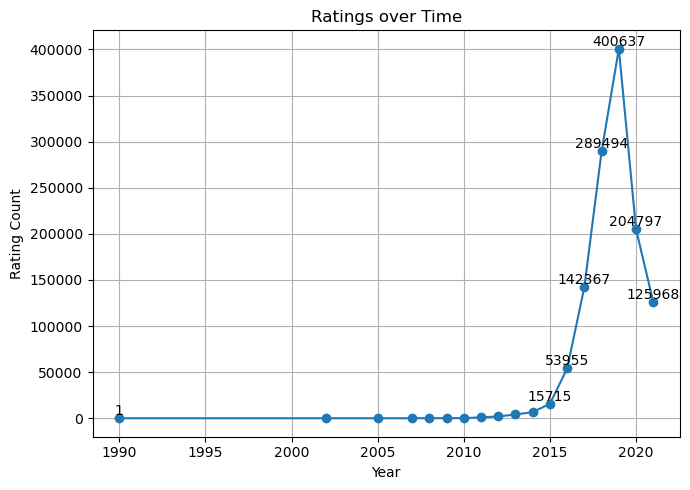

In [27]:
#add a new column `year` to compute the rating count per year
hi_ratings_year = hi_data.withColumn("year", F.year("timestamp"))
rating_count_year = hi_ratings_year.groupBy("year").count().orderBy("year")

#prepare the data for visualization
years = [row['year'] for row in rating_count_year.collect()]
year_counts = [row['count'] for row in rating_count_year.collect()]

plt.figure(figsize=(7, 5))
plt.plot(years, year_counts, marker='o', linestyle='-')
plt.title("Ratings over Time")
plt.xlabel("Year")
plt.ylabel("Rating Count")
plt.grid(True)
plt.tight_layout()

#set a loop to add text in the plot
for i in range(len(years)):
    if i >= 11 or i == 0:
        plt.text(years[i], year_counts[i], str(year_counts[i]), ha='center', va='bottom')

plt.show()

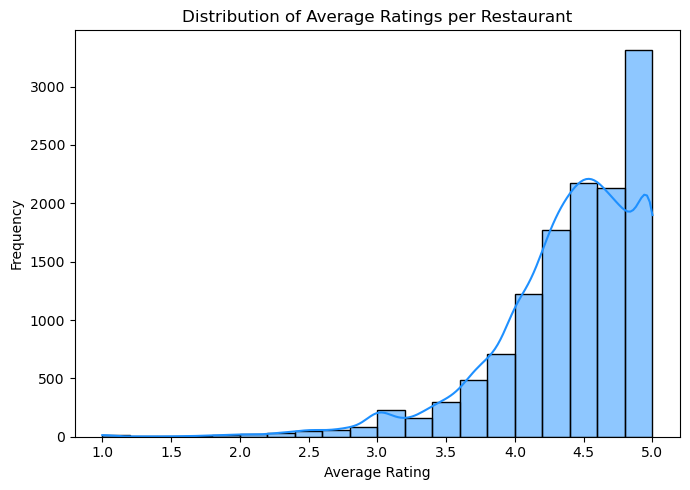

In [12]:
#select the variables for plotting
avg_rating_per_business_pd = hi_data.select("business", "avg_rating").distinct().toPandas()

plt.figure(figsize=(7, 5))
sns.histplot(avg_rating_per_business_pd["avg_rating"], bins=20, kde=True, color="dodgerblue")
plt.title("Distribution of Average Ratings per Restaurant")
plt.xlabel("Average Rating")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

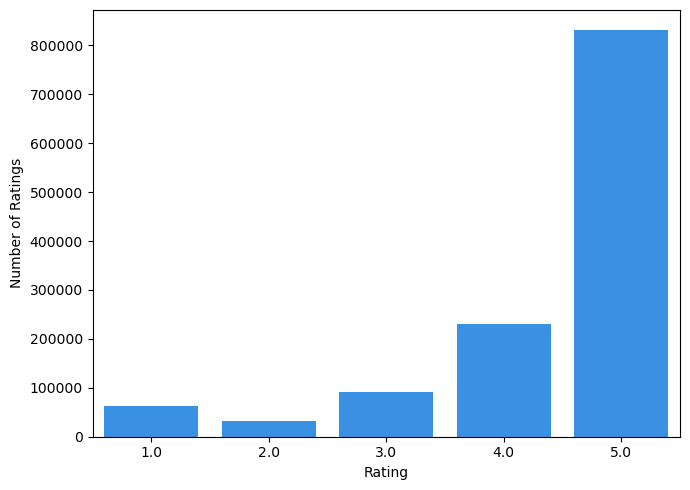

In [21]:
#compute the number of each rating
rating_counts = hi_data.groupBy("rating").count()
rating_counts_pd = rating_counts.toPandas()

plt.figure(figsize=(7, 5))
sns.barplot(x=rating_counts_pd["rating"], y=rating_counts_pd["count"], color="dodgerblue")
plt.xlabel("Rating")
plt.ylabel("Number of Ratings")
plt.tight_layout()
plt.show()

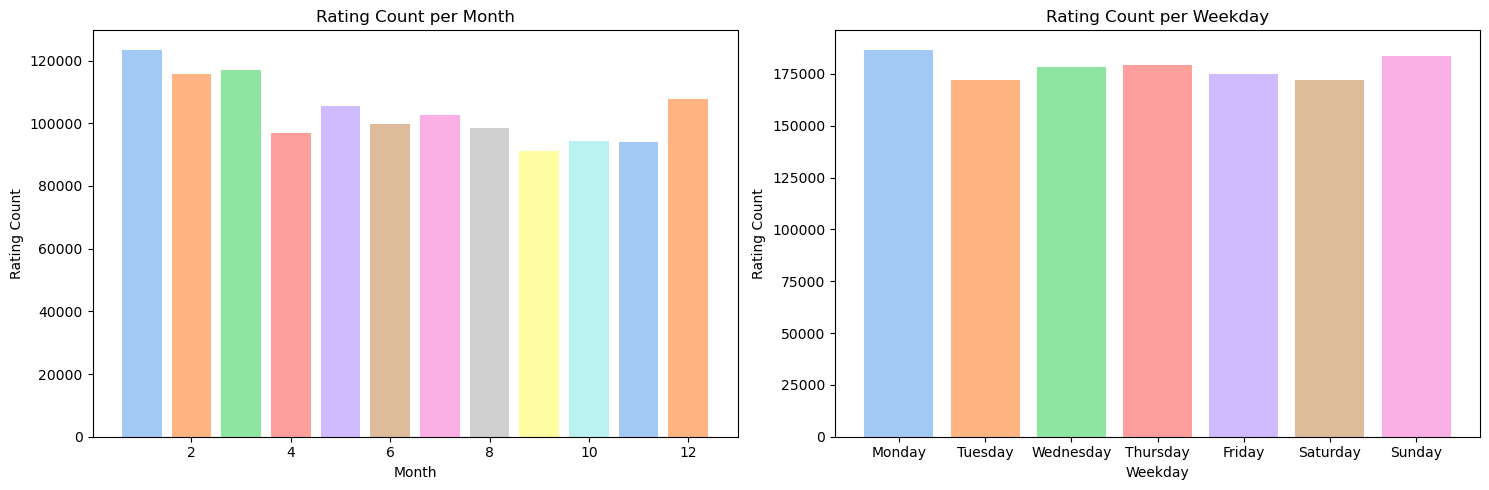

In [28]:
#add a new column `month` to compute the rating count per month
hi_ratings_month = hi_data.withColumn("month", F.month("timestamp"))
rating_count_month = hi_ratings_month.groupBy("month").count().orderBy("month")

#prepare the data for visualization
months = [row['month'] for row in rating_count_month.collect()]
month_counts = [row['count'] for row in rating_count_month.collect()]

#use the color from seaborn palette
month_colors = sns.color_palette("pastel", len(months))

#add a new column `week` to compute the rating count per weekday
hi_ratings_weekday = hi_data.withColumn("weekday", F.dayofweek("timestamp"))
rating_count_week = hi_ratings_weekday.groupBy("weekday").count().orderBy("weekday")

#build a dictionary of weekday for labelling
weekday_dict = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}

#prepare the data for visualization
weekdays = [weekday_dict[row['weekday']] for row in rating_count_week.collect()]
weekday_counts = [row['count'] for row in rating_count_week.collect()]

#use the color from seaborn palette
week_colors = sns.color_palette("pastel", len(weekdays))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.bar(months, month_counts, align='center', color=month_colors)
plt.title("Rating Count per Month")
plt.xlabel("Month")
plt.ylabel("Rating Count")

plt.subplot(1, 2, 2)
plt.bar(weekdays, weekday_counts, align='center', color=week_colors)
plt.title("Rating Count per Weekday")
plt.xlabel("Weekday")
plt.ylabel("Rating Count")

plt.tight_layout()
plt.show()

24/04/02 10:24:02 WARN YarnAllocator: Container from a bad node: container_1712052513530_0002_01_000001 on host: st446-cluster-w07-m.europe-west2-c.c.st446-test1-411720.internal. Exit status: 143. Diagnostics: [2024-04-02 10:24:01.211]Container killed on request. Exit code is 143
[2024-04-02 10:24:01.212]Container exited with a non-zero exit code 143. 
[2024-04-02 10:24:01.212]Killed by external signal
.
24/04/02 10:24:02 ERROR YarnScheduler: Lost executor 1 on st446-cluster-w07-m.europe-west2-c.c.st446-test1-411720.internal: Container from a bad node: container_1712052513530_0002_01_000001 on host: st446-cluster-w07-m.europe-west2-c.c.st446-test1-411720.internal. Exit status: 143. Diagnostics: [2024-04-02 10:24:01.211]Container killed on request. Exit code is 143
[2024-04-02 10:24:01.212]Container exited with a non-zero exit code 143. 
[2024-04-02 10:24:01.212]Killed by external signal
.
24/04/02 10:24:02 WARN TaskSetManager: Lost task 0.0 in stage 77.0 (TID 46) (st446-cluster-w07-m.e

<Figure size 1200x800 with 0 Axes>

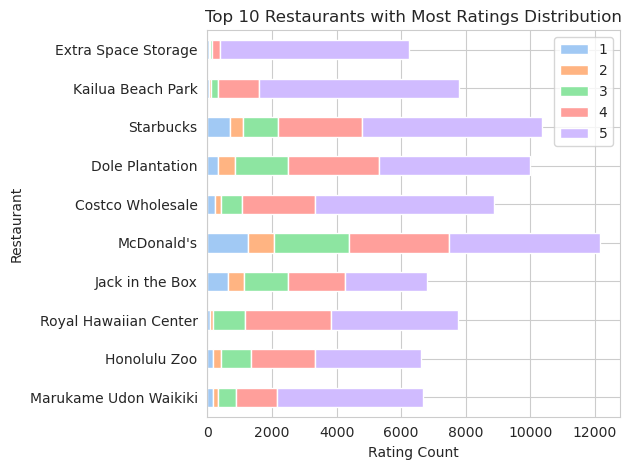

In [18]:
#group by restaurant and calculate the number of ratings per restaurant
restaurant_rating_counts = hi_data.groupBy("name", "rating").count()

#get the top10 restaurants with most ratings
top_restaurants = restaurant_rating_counts.groupBy("name").sum("count").orderBy("sum(count)", ascending=False).limit(10)

#get the ids of these 10 restaurants
top_restaurant_names = [row['name'] for row in top_restaurants.collect()]

#filter out the data of these 10 restaurants by business id
top_restaurant_data = restaurant_rating_counts.filter(restaurant_rating_counts.name.isin(top_restaurant_names))

#group by restaurant and rating to build a lookup table 
#and turn it into dataframe
pivoted_data = top_restaurant_data.groupBy("name").pivot("rating", [1, 2, 3, 4, 5]).sum("count")
pandas_data = pivoted_data.toPandas()

#set the color
sns.set_style("whitegrid")
palette = sns.color_palette("pastel", 10)

plt.figure(figsize=(12, 8))
plot = pandas_data.plot(kind="barh", stacked=True, color=palette)
plot.set_yticklabels(pandas_data['name'])
plt.title("Top 10 Restaurants with Most Ratings Distribution")
plt.xlabel("Rating Count")
plt.ylabel("Restaurant")
plt.tight_layout()
plt.show()

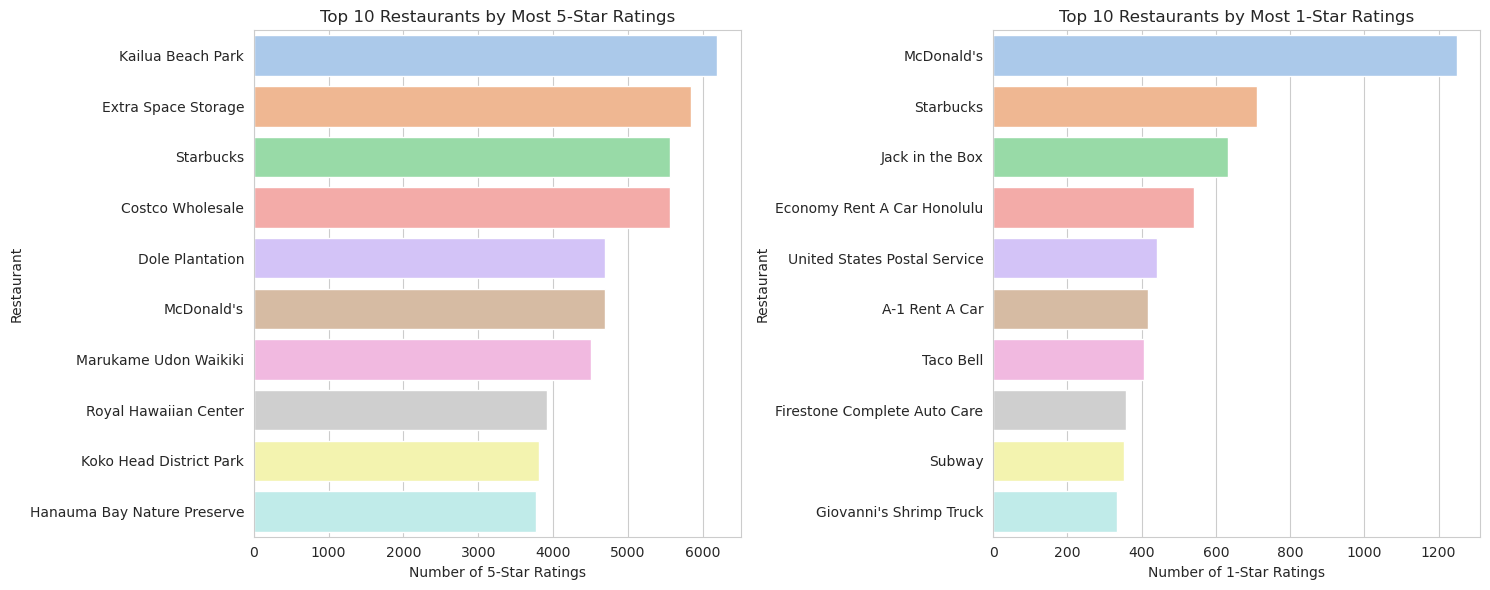

In [20]:
#compute the five star rating count of each restaurant
five_star_counts = hi_data.filter(hi_data.rating == 5).groupBy("name").count()
#compute the one star rating count of each restaurant
one_star_counts = hi_data.filter(hi_data.rating == 1).groupBy("name").count()

#find the top10 restaurants with most five star rating
top_five_star_restaurants = five_star_counts.orderBy("count", ascending=False).limit(10)
top_five_star_restaurants = top_five_star_restaurants.toPandas()
#find the top10 restaurants with most one star rating
top_one_star_restaurants = one_star_counts.orderBy("count", ascending=False).limit(10)
top_one_star_restaurants = top_one_star_restaurants.toPandas()

#set the color
palette = sns.color_palette("pastel", 10)
#set up 2 subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.barplot(data=top_five_star_restaurants, x='count', y='name', palette=palette, ax=axes[0])
axes[0].set_title("Top 10 Restaurants by Most 5-Star Ratings")
axes[0].set_xlabel("Number of 5-Star Ratings")
axes[0].set_ylabel("Restaurant")

sns.barplot(data=top_one_star_restaurants, x='count', y='name', palette=palette, ax=axes[1])
axes[1].set_title("Top 10 Restaurants by Most 1-Star Ratings")
axes[1].set_xlabel("Number of 1-Star Ratings")
axes[1].set_ylabel("Restaurant")

plt.tight_layout()
plt.show()


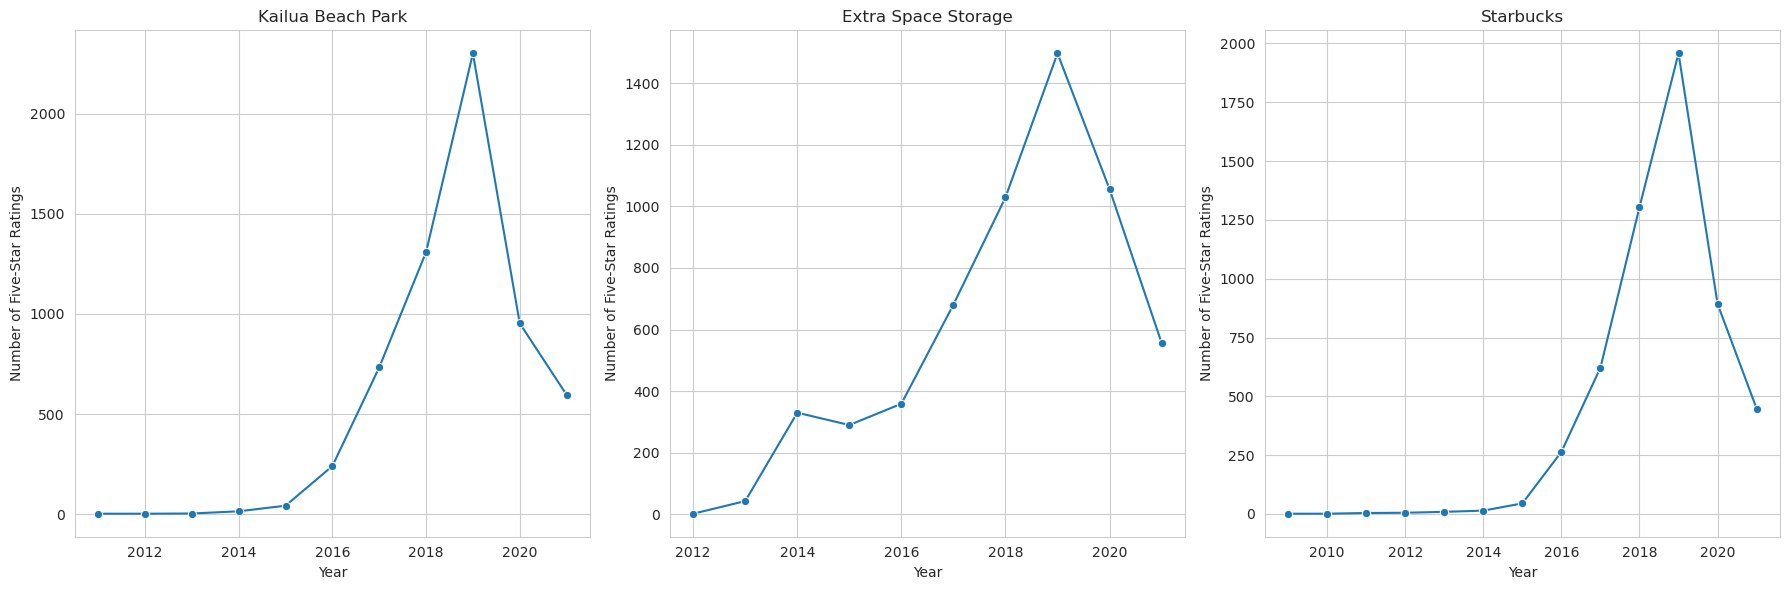

In [21]:
#compute 5-star rating count of the top3 resturants per year
top3_five_star_counts = hi_data.filter(hi_ratings.rating == 5).groupBy("name", F.year("timestamp").alias("year")).count()

#find top3 restaurants with most 5-star ratings
top_three_restaurants = top3_five_star_counts.groupBy("name").sum("count").orderBy("sum(count)", ascending=False).limit(3)

#set up 3 subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

for i, restaurant in enumerate(top_three_restaurants.collect()):
    restaurant_name = restaurant['name']
    restaurant_data = top3_five_star_counts.filter(top3_five_star_counts.name == restaurant_name).toPandas()
    
    #line plot
    sns.lineplot(data=restaurant_data, x='year', y='count', marker='o', ax=axes[i])
    axes[i].set_title(f"{restaurant_name}")
    axes[i].set_xlabel("Year")
    axes[i].set_ylabel("Number of Five-Star Ratings")
    axes[i].grid(True)

plt.tight_layout()
plt.show()

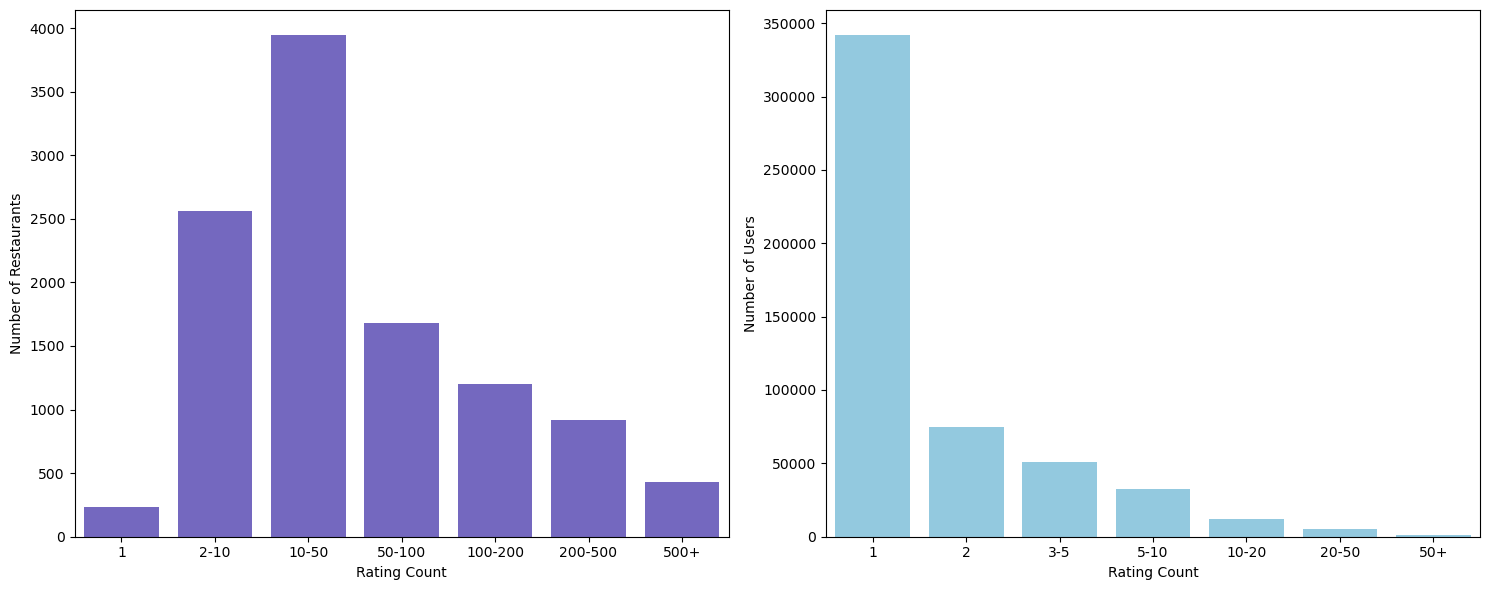

In [22]:
# Group by restaurant and calculate the number of ratings per restaurant
restaurant_rating_counts = hi_data.groupBy("name").count()

# Define the range and label for restaurant rating counts
splits_restaurant = [1, 2, 10, 50, 100, 200, 500, float('inf')]
labels_restaurant = ['1', '2-10','10-50', '50-100', '100-200', '200-500', '500+']

# Bucketize the restaurant rating counts and add labels
bucketizer_restaurant = Bucketizer(splits=splits_restaurant, inputCol='count', outputCol='rating_count_bin')
restaurant_rating_counts_with_bins = bucketizer_restaurant.transform(restaurant_rating_counts)
restaurant_rating_counts_with_bins = restaurant_rating_counts_with_bins.withColumn('rating_count_bin_label', F.col('rating_count_bin').cast('int'))
restaurant_rating_counts_with_bins = restaurant_rating_counts_with_bins.replace(float('inf'), len(splits_restaurant)-1, 'rating_count_bin_label')

# Convert restaurant rating counts data to Pandas DataFrame
rating_counts_by_bin_restaurant = restaurant_rating_counts_with_bins.groupby('rating_count_bin_label').count()
counts_by_bin_restaurant = rating_counts_by_bin_restaurant.toPandas()

# Group by user and calculate the number of ratings per user
user_rating_counts = hi_data.groupby('user').count()

# Define the range and label for user rating counts
splits_user = [1, 2, 3, 5, 10, 20, 50, float('inf')]
labels_user = ['1', '2', '3-5', '5-10', '10-20', '20-50', '50+']

# Bucketize the user rating counts and add labels
bucketizer_user = Bucketizer(splits=splits_user, inputCol='count', outputCol='rating_count_bin')
user_rating_counts_with_bins = bucketizer_user.transform(user_rating_counts)
user_rating_counts_with_bins = user_rating_counts_with_bins.withColumn('rating_count_bin_label', F.col('rating_count_bin').cast('int'))
user_rating_counts_with_bins = user_rating_counts_with_bins.replace(float('inf'), len(splits_user)-1, 'rating_count_bin_label')

# Calculate the number of ratings per user
rating_counts_by_bin_user = user_rating_counts_with_bins.groupby('rating_count_bin_label').count()

# Convert it into a dataframe
counts_by_bin_user = rating_counts_by_bin_user.toPandas()

# Plotting both graphs side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot for distribution of rating counts per restaurant
sns.barplot(x='rating_count_bin_label', y='count', data=counts_by_bin_restaurant, color='slateblue', ax=axes[0])
#axes[0].set_title('Distribution of Rating Counts per Restaurant')
axes[0].set_xlabel('Rating Count')
axes[0].set_ylabel('Number of Restaurants')
axes[0].set_xticks(range(len(labels_restaurant)))
axes[0].set_xticklabels(labels_restaurant)

# Plot for distribution of rating counts per user
sns.barplot(x='rating_count_bin_label', y='count', data=counts_by_bin_user, color='skyblue', ax=axes[1])
#axes[1].set_title('Distribution of Rating Counts per User')
axes[1].set_xlabel('Rating Count')
axes[1].set_ylabel('Number of Users')
axes[1].set_xticks(range(len(labels_user)))
axes[1].set_xticklabels(labels_user)

plt.tight_layout()
plt.show()

### 2.2 Analysis of User

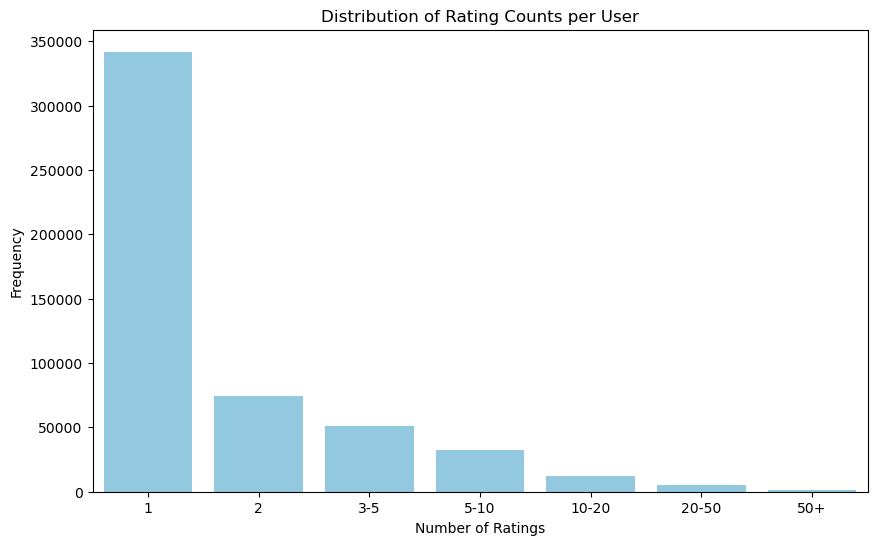

In [17]:
#compute the number of ratings of each user
user_rating_counts = hi_data.groupby('user').count()

#define the range and label 
splits = [1, 2, 3, 5, 10, 20, 50, float('inf')]
labels = ['1', '2', '3-5', '5-10', '10-20', '20-50', '50+']

bucketizer = Bucketizer(splits=splits, inputCol='count', outputCol='rating_count_bin')

#divide the number of scores into buckets and add labels
user_rating_counts_with_bins = bucketizer.transform(user_rating_counts)
user_rating_counts_with_bins = user_rating_counts_with_bins.withColumn('rating_count_bin_label', F.col('rating_count_bin').cast('int'))
user_rating_counts_with_bins = user_rating_counts_with_bins.replace(float('inf'), len(splits)-1, 'rating_count_bin_label')

rating_counts_by_bin = user_rating_counts_with_bins.groupby('rating_count_bin_label').count()

#convert it into dataframe
counts_by_bin = rating_counts_by_bin.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='rating_count_bin_label', y='count', data=counts_by_bin, color='skyblue')
plt.title('Distribution of Rating Counts per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.show()

24/04/02 14:16:58 WARN YarnAllocator: Container from a bad node: container_1712066405402_0001_01_000003 on host: st446-cluster-w07-m.europe-west2-c.c.st446-test1-411720.internal. Exit status: 143. Diagnostics: [2024-04-02 14:16:57.280]Container killed on request. Exit code is 143
[2024-04-02 14:16:57.280]Container exited with a non-zero exit code 143. 
[2024-04-02 14:16:57.281]Killed by external signal
.
24/04/02 14:16:58 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 3 for reason Container from a bad node: container_1712066405402_0001_01_000003 on host: st446-cluster-w07-m.europe-west2-c.c.st446-test1-411720.internal. Exit status: 143. Diagnostics: [2024-04-02 14:16:57.280]Container killed on request. Exit code is 143
[2024-04-02 14:16:57.280]Container exited with a non-zero exit code 143. 
[2024-04-02 14:16:57.281]Killed by external signal
.
24/04/02 14:16:58 ERROR YarnScheduler: Lost executor 3 on st446-cluster-w07-m.europe-west2-c.c.st446-test

<Figure size 1200x800 with 0 Axes>

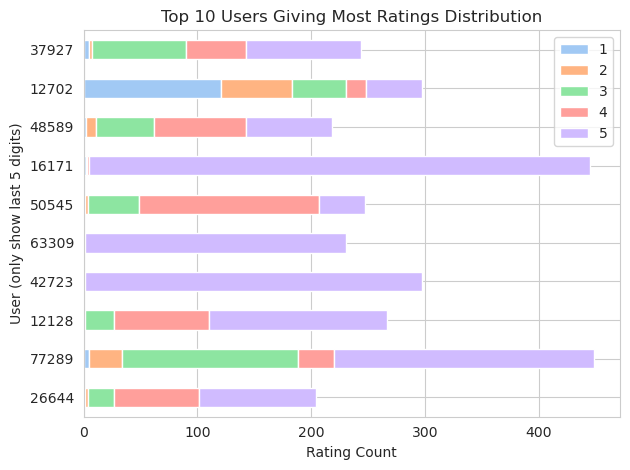

In [28]:
#group by user and calculate the number of ratings per user
user_rating_counts = hi_data.groupBy("user", "rating").count()

#get the top10 restaurants with most ratings
top_users = user_rating_counts.groupBy("user").sum("count").orderBy("sum(count)", ascending=False).limit(10)

#get the ids of these 10 restaurants
top_user_ids = [row['user'] for row in top_users.collect()]

#filter out the data of these 10 restaurants by business id
top_user_data = user_rating_counts.filter(user_rating_counts.user.isin(top_user_ids))

#group by restaurant and rating to build a lookup table 
#and turn it into dataframe
pivoted_data = top_user_data.groupBy("user").pivot("rating", [1, 2, 3, 4, 5]).sum("count")
pandas_data = pivoted_data.toPandas()
pandas_data['short_user'] = pandas_data['user'].apply(lambda x: x[-5:])

#set the color
sns.set_style("whitegrid")
palette = sns.color_palette("pastel", 10)

plt.figure(figsize=(12, 8))
plot = pandas_data.plot(kind="barh", stacked=True, color=palette)
plot.set_yticklabels(pandas_data['short_user'])
plt.title("Top 10 Users Giving Most Ratings Distribution")
plt.xlabel("Rating Count")
plt.ylabel("User (only show last 5 digits)")
plt.tight_layout()
plt.show()